In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

In [68]:
df = pd.read_csv('/Users/edoardo/Documents/Projects/KGE_Quality/Development/giant_matrix_2024_04_09.csv')
#df = df[df['model'].str.contains('ComplEx')  == True]
df = df[df['dataset'].str.contains('WN18|YAGO|FB15k', regex=True)  == True]
#df = df[df.c_split == 0]

df = df[~df['dataset'].str.contains('Kinship')  == True]

df = df[~df['dataset'].str.contains('FB15k237')  == True]
df = df[~df['dataset'].str.contains('WN18RR')  == True]

df_baseline = df[df.value == 0]
df = df[df['property'].str.contains('pagerank|harmonic_centrality|random', regex=True)  == True]
df_bottom = df[df.value < 0]


In [69]:
df['training_duration'].sum()

3625484.6487915516

In [70]:
def join_df(df_obj):
    df_obj = df_obj.merge(df_baseline, how='inner', on=['dataset', 'model', 'c_split'])
    df_obj['ratio_performance_min'] = df_obj['results_min_hits_at_10_x'] / df_obj['results_min_hits_at_10_y']
    df_obj['ratio_performance'] = df_obj['results_hits_at_10_x'] / df_obj['results_hits_at_10_y']
    df_obj['ratio_order'] = df_obj['order_x'] / df_obj['order_y']
    df_obj['ratio_size'] = df_obj['size_x'] / df_obj['size_y']
    df_obj['ratio_gpu_energy'] = df_obj['training_gpu_energy_x'] / df_obj['training_gpu_energy_y']
    df_obj['ratio_duration_training'] = df_obj['training_duration_x'] / df_obj['training_duration_y']
    
    df_obj['ratio_testing_entities'] = df_obj['testing_entities_x'] / df_obj['testing_entities_y']
    df_obj['ratio_testing_triples'] = df_obj['testing_triples_x'] / df_obj['testing_triples_y']
    return df_obj

df_bottom = join_df(df_bottom)

<Axes: xlabel='value_x', ylabel='ratio_performance'>

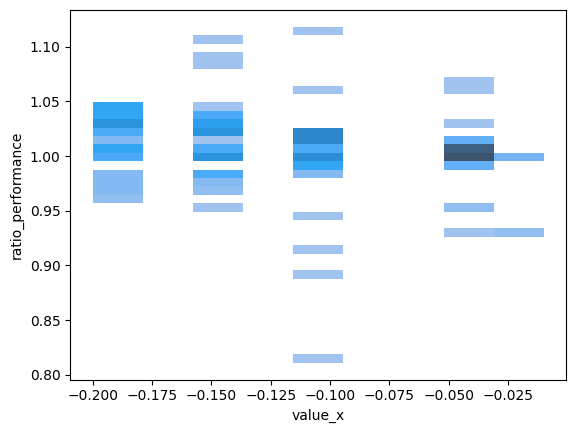

In [71]:
sns.histplot(df_bottom, x='value_x', y='ratio_performance')

<Axes: xlabel='ratio_performance', ylabel='Count'>

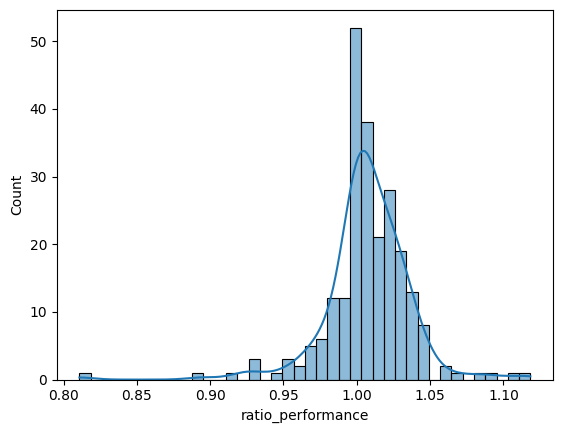

In [72]:
sns.histplot(df_bottom, x='ratio_performance', kde=True)

In [73]:
camilla = df_bottom.groupby(['dataset', 'model'])[['ratio_performance', 'ratio_performance_min', 'ratio_order', 'ratio_size']].mean()


In [74]:
camilla

ratio_performance  ratio_performance_min  ratio_order  \
dataset model                                                            
FB15k   ComplEx           0.995204               1.062447     0.880976   
        RotatE            0.992975               1.020740     0.874228   
        TransE            0.994210               1.022865     0.874228   
WN18    ComplEx           1.019517               1.039454     0.878449   
        RotatE            1.018187               1.021094     0.874951   
        TransE            1.018579               1.026284     0.874951   
YAGO310 ComplEx           0.998412               1.003667     0.878510   
        RotatE            1.015120               0.883710     0.874978   
        TransE            1.015614               0.922994     0.874978   

                 ratio_size  
dataset model                
FB15k   ComplEx    0.931853  
        RotatE     0.955796  
        TransE     0.955796  
WN18    ComplEx    0.896724  
        RotatE     0.913250  
        TransE     0.913250  
YAGO310 ComplEx    0.909043  
        RotatE     0.928381  
        TransE     0.928381

<Axes: xlabel='ratio_performance', ylabel='Count'>

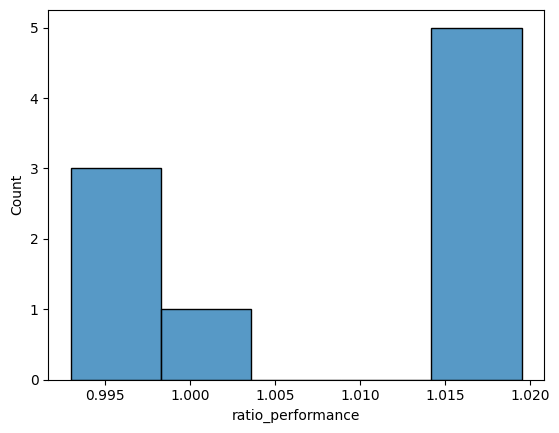

In [75]:
sns.histplot(camilla, x='ratio_performance')

<Axes: xlabel='ratio_performance_min', ylabel='Count'>

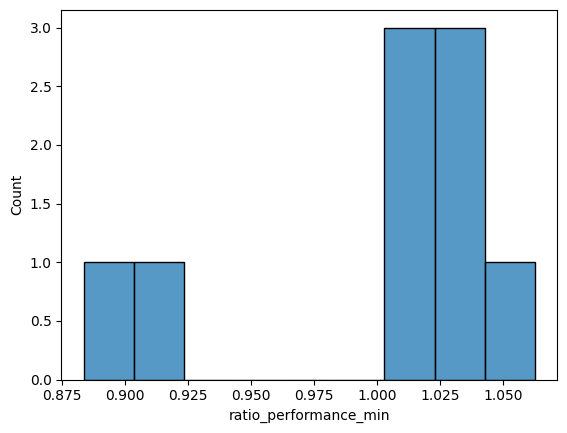

In [76]:
sns.histplot(camilla, x='ratio_performance_min')

In [77]:
df_bottom_2 = df_bottom[df_bottom['property_x'].str.contains('pagerank|harmonic_centrality|random', regex=True)  == True]
camilla_2 = df_bottom_2.groupby(['dataset', 'model', 'value_x', 'property_x'])[['training_duration_x', 'training_duration_y', 'ratio_performance', 'ratio_performance_min', 'ratio_duration_training', 'ratio_order', 'ratio_size', 'ratio_gpu_energy', 'information_loss_x', 'results_hits_at_10_x', 'results_min_hits_at_10_x', 'results_hits_at_10_y', 'results_min_hits_at_10_y', 'ratio_testing_entities', 'ratio_testing_triples']].mean().reset_index()


In [78]:
df_bottom_2.property_x.unique()

array(['harmonic_centrality', 'pagerank', 'random'], dtype=object)

In [79]:
color_code = {'TransE': 'red', 'RotatE': 'orange', 'ComplEx': 'green'}

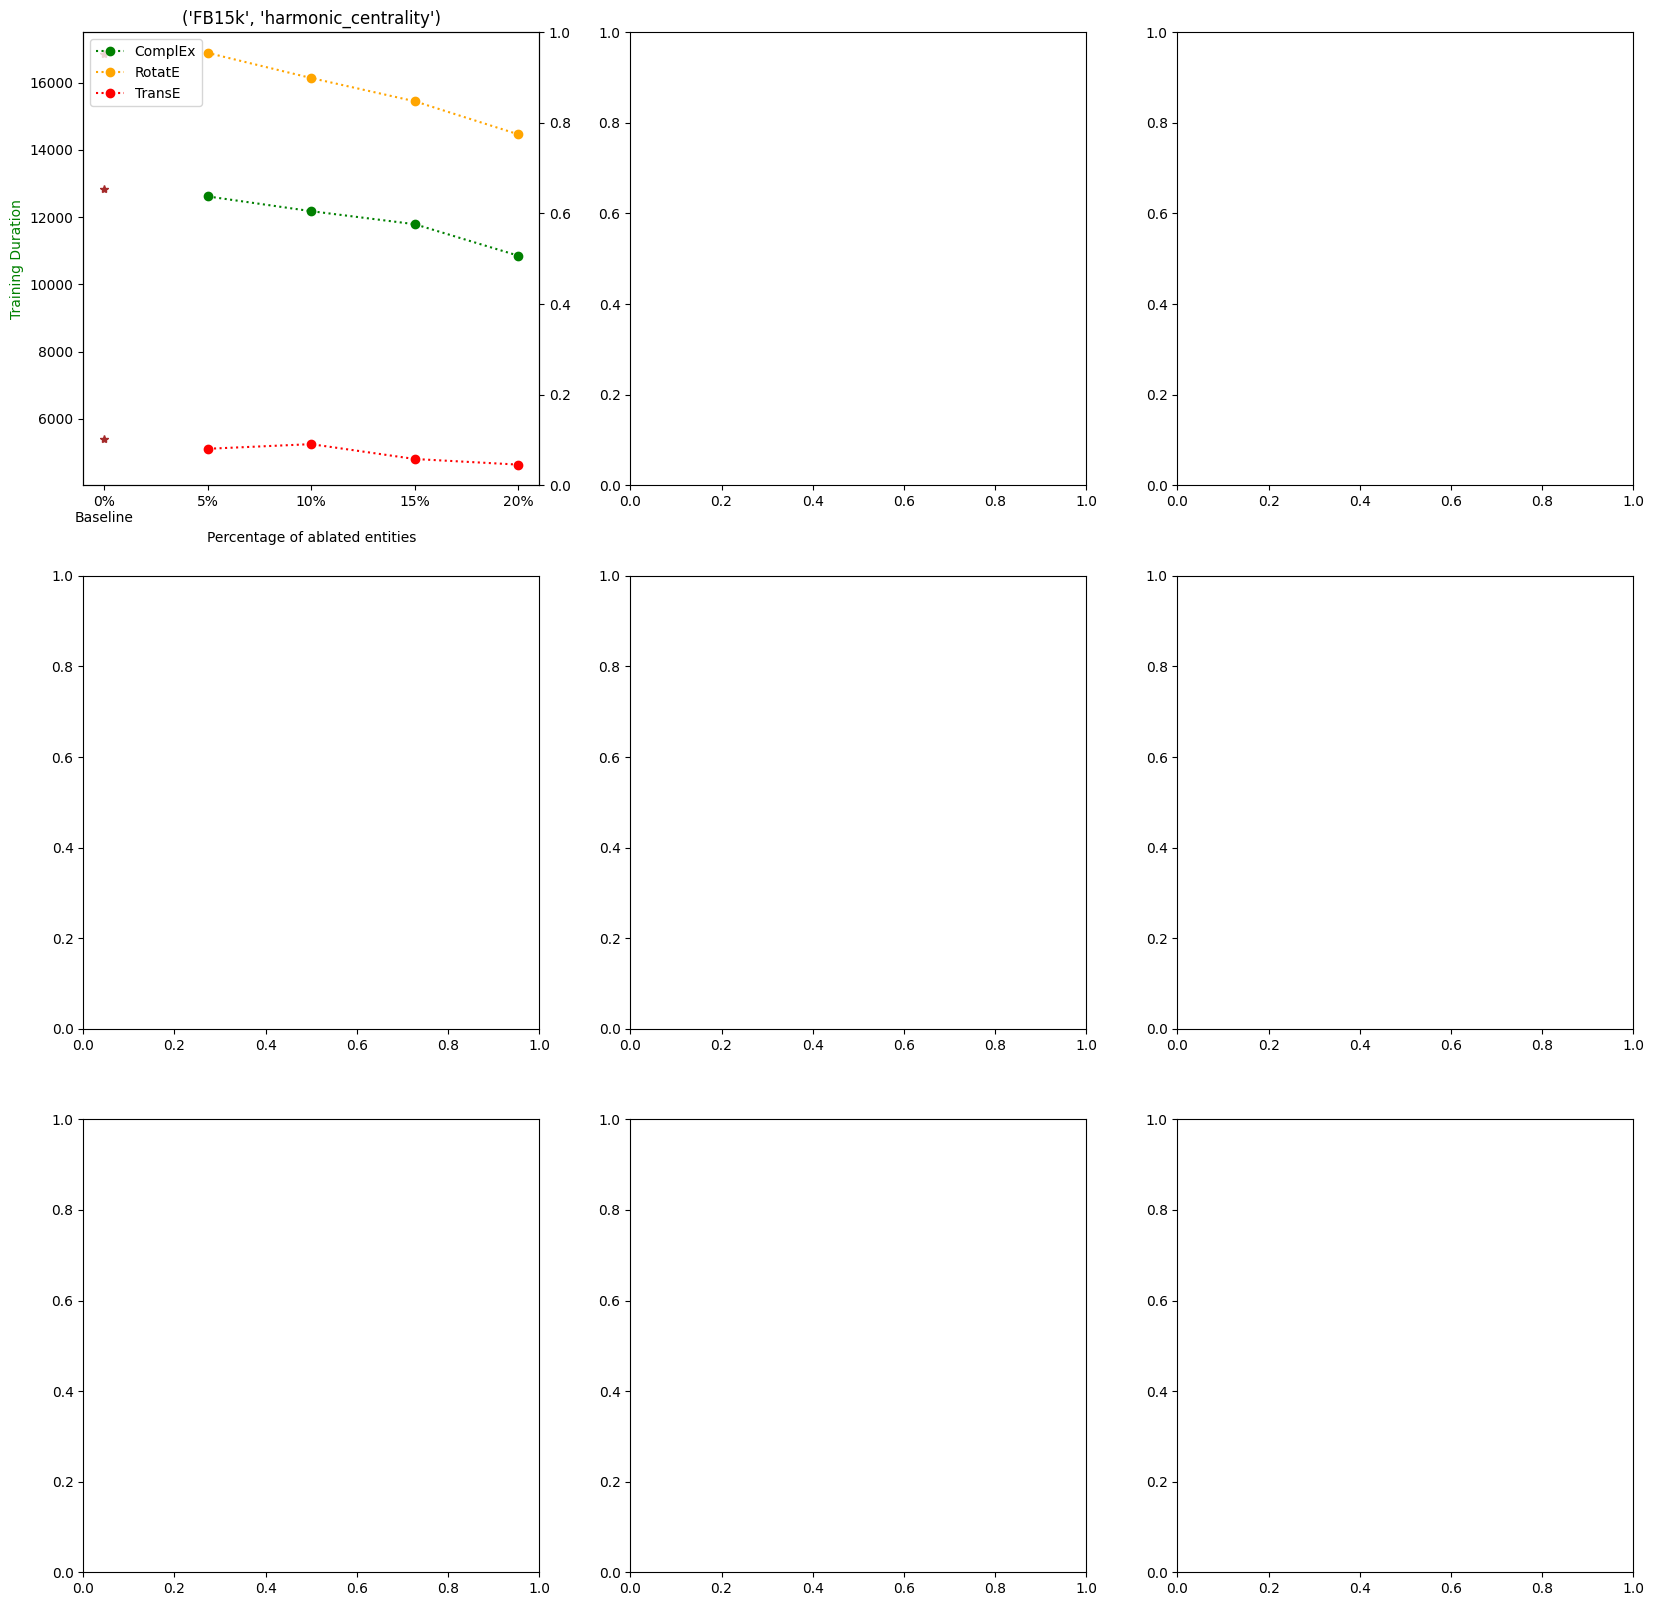

In [80]:
n_rows = 3
n_cols = 3

fig, axs = plt.subplots(n_rows, n_cols,  figsize=(20, 20))

for index, (name, df_group) in enumerate(camilla_2.groupby(['dataset', 'property_x'])):

    i = index // n_cols  # Integer division to get the row index
    j = index % n_cols   # Modulo operation to get the column index

    c_ax = axs[i, j]
    
    ax2 = c_ax.twinx()
    #ax1.plot(x, y1, 'g.')

    for model_name, sub_df_model in df_group.groupby('model'):
        x = sub_df_model['value_x']
        y2 = 1 - sub_df_model['ratio_testing_triples']
        y2_bis = 1 - sub_df_model['ratio_testing_entities']
        y2_bis_bis = 1 - sub_df_model['information_loss_x']

        y1 = sub_df_model['training_duration_x']
        
        c_ax.plot(x, y1, color=color_code[model_name], linestyle='dotted', marker='o', label=model_name)
        c_ax.plot(0, sub_df_model['training_duration_y'].iloc[0], color='brown', linestyle='', marker='*')
        
    #ax2.plot(0, 0, color='blue', linestyle='', marker='P')


    
    #ax2.plot(x, y2, color='blue', linestyle='dashed', marker='o', label='Triples')
    #ax2.plot(x, y2_bis, color='cyan', linestyle='dashed', marker='o', label='Entitis')
    #ax2.plot(x, y2_bis_bis, color='dodgerblue', linestyle='dashed', marker='o', label='PageRank')
    
    c_ax.set_xlabel('Percentage of ablated entities')
    c_ax.set_ylabel('Training Duration', color='g')
    #ax2.set_ylabel('Information Loss', color='b')

    c_ax.set_xticks([-0.20, -0.15, -0.10, -0.05, 0])
    c_ax.set_xticklabels(['20%', '15%', '10%', '5%', '0%\nBaseline'])
    
    #ax2.set_ylim(0.0, 0.25)
    #c_ax.set_ylim(0, 1.1)

    c_ax.set_title('{}'.format(name))

    c_ax.legend(loc='upper left')
    #ax2.legend(loc='center left')

    c_ax.invert_xaxis()
    #ax2.legend(loc='lower right')
    break

fig.savefig('energy_new_info.pdf')
    
    

('FB15k', 'harmonic_centrality')


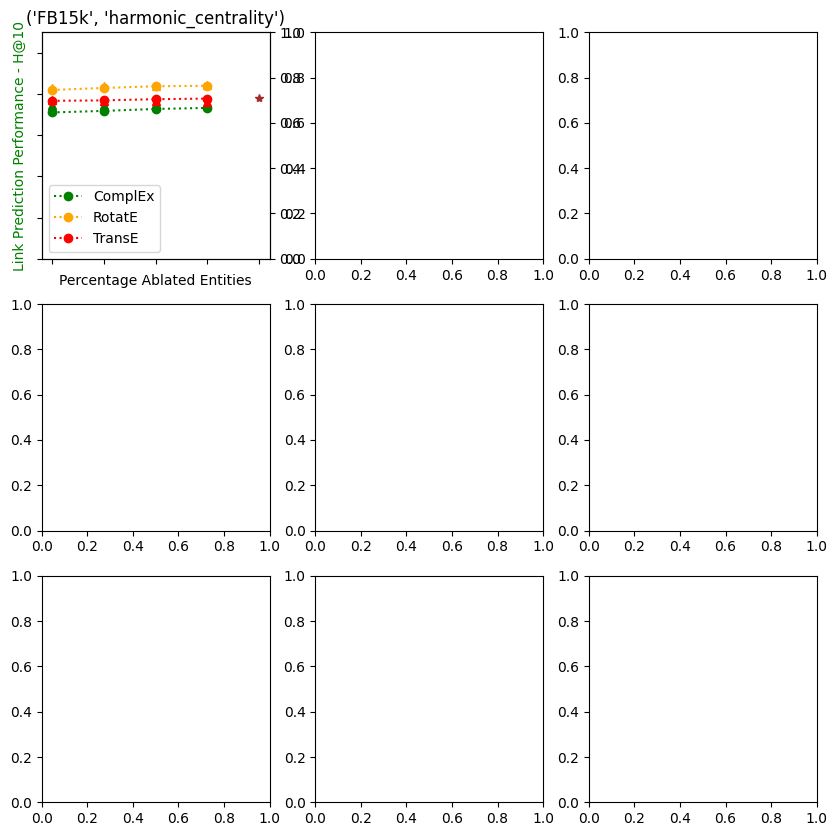

In [85]:
n_rows = 3
n_cols = 3

fig, axs = plt.subplots(n_rows, n_cols,  figsize=(10, 10))

for index, (name, df_group) in enumerate(camilla_2.groupby(['dataset', 'property_x'])):

    i = index // n_cols  # Integer division to get the row index
    j = index % n_cols   # Modulo operation to get the column index
    print(name)

    c_ax = axs[i, j]
    
    ax2 = c_ax.twinx()
    #ax1.plot(x, y1, 'g.')

    for model_name, sub_df_model in df_group.groupby('model'):
        x = sub_df_model['value_x']

        y2 = sub_df_model['ratio_testing_triples']
        y2_bis = sub_df_model['ratio_testing_entities']
        y2_bis_bis = sub_df_model['information_loss_x']


        
        y1 = sub_df_model['results_hits_at_10_x']
        y1_min = sub_df_model['results_min_hits_at_10_x']
        
        c_ax.plot(x, y1, color=color_code[model_name], linestyle='dotted', marker='o', label=model_name)
        c_ax.plot(x, y1_min, color=color_code[model_name], linestyle='', marker='^')

    c_ax.plot(0, sub_df_model['results_hits_at_10_y'].iloc[0], color='brown', linestyle='', marker='*')
    #ax2.plot(0, 1, color='blue', linestyle='', marker='*')


    
    #ax2.plot(x, y2, color='blue', linestyle='dashed', marker='o', label='Triples')
    #ax2.plot(x, y2_bis, color='cyan', linestyle='dashed', marker='o', label='Entitis')
    #ax2.plot(x, y2_bis_bis, color='dodgerblue', linestyle='dashed', marker='o', label='PageRank')
    
    c_ax.set_xlabel('Percentage Ablated Entities')
    c_ax.set_ylabel('Link Prediction Performance - H@10', color='g')
    #ax2.set_ylabel('Information Loss page-rank', color='b')

    c_ax.set_xticks([-0.20, -0.15, -0.10, -0.05, 0])
    c_ax.set_xticklabels(['20%', '15%', '10%', '5%', '0%\nBaseline'])
    
    #ax2.set_ylim(0.75, 1.05)
    c_ax.set_ylim(0, 1.1)

    #c_ax.set_title('{}'.format(name))

    c_ax.legend(loc='lower left')
    #ax2.legend(loc='center left')

    #c_ax.invert_xaxis()
    #ax2.legend(loc='lower right')

    c_ax.xaxis.set_ticklabels([])
    c_ax.yaxis.set_ticklabels([])
    break
    

#fig.savefig('performance_new_info.pdf')
    

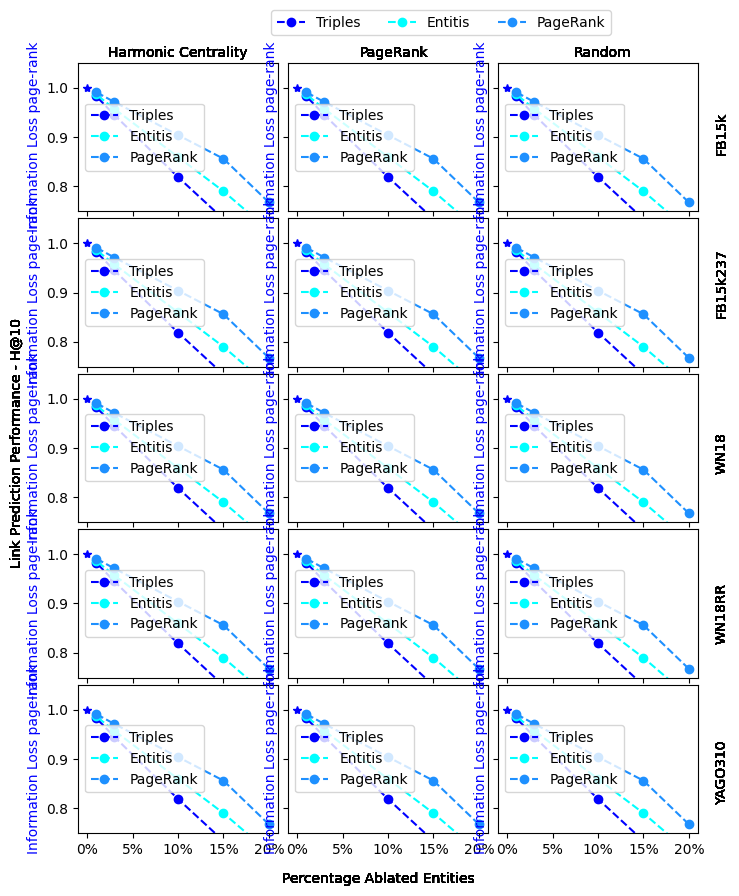

In [158]:

n_rows = 5
n_cols = 3

fig, axs = plt.subplots(n_rows, n_cols, sharex=True, sharey=True, figsize=(8, 10), squeeze=True)

edo = 1


for index, (name, df_group) in enumerate(camilla_2.groupby(['dataset', 'property_x'])):

    i = index // n_cols  # Integer division to get the row index
    j = index % n_cols   # Modulo operation to get the column index

    c_ax = axs[i, j]
    
    
    #ax1.plot(x, y1, 'g.')


    for model_name, sub_df_model in df_group.groupby('model'):
        x = sub_df_model['value_x']

        y2 = sub_df_model['ratio_testing_triples']
        y2_bis = sub_df_model['ratio_testing_entities']
        y2_bis_bis = sub_df_model['information_loss_x']


        
        y1 = sub_df_model['results_hits_at_10_x']
        y1_min = sub_df_model['results_min_hits_at_10_x']
        
        c_ax.plot(x, y1, color=color_code[model_name], linestyle='dotted', marker='o', label=model_name)
        c_ax.plot(x, y1_min, color=color_code[model_name], linestyle='', marker='^')
        

    c_ax.plot(0, sub_df_model['results_hits_at_10_y'].iloc[0], color='brown', linestyle='', marker='*', label='Baseline')


    c_ax.set_xticks([-0.20, -0.15, -0.10, -0.05, 0])
    c_ax.set_xticklabels(['20%', '15%', '10%', '5%', '0%'])

    c_ax.set_ylim(0.22, 1.05)


    #c_ax.set_title('{}'.format(name))

    #c_ax.legend(loc='lower left')

    

    fig.text(0.5, 0.06, 'Percentage Ablated Entities', ha='center')
    fig.text(0.04, 0.5, 'Link Prediction Performance - H@10', va='center', rotation='vertical')

    fig.text(0.25, 0.89, 'Harmonic Centrality', va='center', ha='center', fontweight=1)
    fig.text(0.52, 0.89, 'PageRank', va='center', ha='center', fontweight=1)
    fig.text(0.78, 0.89, 'Random', va='center', ha='center', fontweight=1)

    fig.text(0.93, 0.81, 'FB15k', ha='center', va='center', rotation='vertical')
    fig.text(0.93, 0.66, 'FB15k237', ha='center', va='center', rotation='vertical')
    fig.text(0.93, 0.49, 'WN18', ha='center', va='center', rotation='vertical')
    fig.text(0.93, 0.33, 'WN18RR', ha='center', va='center', rotation='vertical')
    fig.text(0.93, 0.17, 'YAGO310', ha='center', va='center', rotation='vertical')

    if index == 0:
        handles, labels = c_ax.get_legend_handles_labels()
        fig.legend(handles, labels, bbox_to_anchor=(0.8,0.94), ncols=4)

        c_ax.invert_xaxis()

plt.subplots_adjust(wspace=0.05, hspace=0.05)

fig.savefig('/Users/edoardo/Downloads/edo.pdf')
    # FB15k, FB15k237, WN18, WN18RR, YAGO310



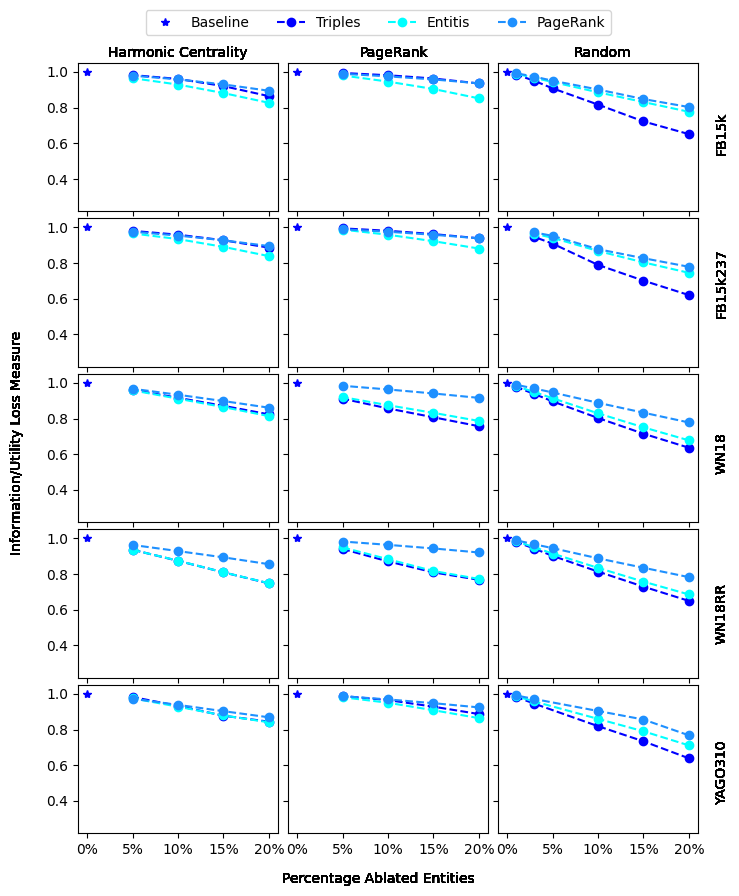

In [163]:

n_rows = 5
n_cols = 3

fig, axs = plt.subplots(n_rows, n_cols, sharex=True, sharey=True, figsize=(8, 10), squeeze=True)

edo = 1


for index, (name, df_group) in enumerate(camilla_2.groupby(['dataset', 'property_x'])):

    i = index // n_cols  # Integer division to get the row index
    j = index % n_cols   # Modulo operation to get the column index

    for model_name, sub_df_model in df_group.groupby('model'):
        x = sub_df_model['value_x']
    
        y2 = sub_df_model['ratio_testing_triples']
        y2_bis = sub_df_model['ratio_testing_entities']
        y2_bis_bis = sub_df_model['information_loss_x']
        

    c_ax = axs[i, j]

    
    
    
    c_ax.plot(0, 1, color='blue', linestyle='', marker='*', label='Baseline')


    
    c_ax.plot(x, y2, color='blue', linestyle='dashed', marker='o', label='Triples')
    c_ax.plot(x, y2_bis, color='cyan', linestyle='dashed', marker='o', label='Entitis')
    c_ax.plot(x, y2_bis_bis, color='dodgerblue', linestyle='dashed', marker='o', label='PageRank')



    
    c_ax.set_ylim(0.75, 1.05)

    c_ax.set_xticks([-0.20, -0.15, -0.10, -0.05, 0])
    c_ax.set_xticklabels(['20%', '15%', '10%', '5%', '0%'])

    c_ax.set_ylim(0.22, 1.05)


    #c_ax.set_title('{}'.format(name))

    #c_ax.legend(loc='lower left')

    

    fig.text(0.5, 0.06, 'Percentage Ablated Entities', ha='center')
    fig.text(0.04, 0.5, 'Information/Utility Loss Measure', va='center', rotation='vertical')

    fig.text(0.25, 0.89, 'Harmonic Centrality', va='center', ha='center', fontweight=1)
    fig.text(0.52, 0.89, 'PageRank', va='center', ha='center', fontweight=1)
    fig.text(0.78, 0.89, 'Random', va='center', ha='center', fontweight=1)

    fig.text(0.93, 0.81, 'FB15k', ha='center', va='center', rotation='vertical')
    fig.text(0.93, 0.66, 'FB15k237', ha='center', va='center', rotation='vertical')
    fig.text(0.93, 0.49, 'WN18', ha='center', va='center', rotation='vertical')
    fig.text(0.93, 0.33, 'WN18RR', ha='center', va='center', rotation='vertical')
    fig.text(0.93, 0.17, 'YAGO310', ha='center', va='center', rotation='vertical')

    if index == 0:
        handles, labels = c_ax.get_legend_handles_labels()
        fig.legend(handles, labels, bbox_to_anchor=(0.8,0.94), ncols=4)

        c_ax.invert_xaxis()

plt.subplots_adjust(wspace=0.05, hspace=0.05)

fig.savefig('/Users/edoardo/Downloads/edo2.pdf')
    # FB15k, FB15k237, WN18, WN18RR, YAGO310